# NB03: Data Visualisation

In [23]:
import requests
from dotenv import load_dotenv
from functions import *
from bs4 import BeautifulSoup
from pprint import pprint
from auth import *
import base64
import os
import pandas as pd
import json
import csv
import string
import lyricsgenius
import sqlite3
from sqlalchemy import create_engine
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
#! pip install nltk
import nltk
from nltk.corpus import stopwords
import seaborn as sns
#! pip install wordcloud
from os import path
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import colormaps as cm
import cv2
from scipy.interpolate import splprep, splev 
from IPython.display import Image, display

In [24]:
engine = create_engine('sqlite:///../data/spotify_data.db')

# Query to load the top_tracks table from the SQLite database
query = "SELECT lyrics, gender FROM top_tracks"

# Load data into pandas DataFrame
df = pd.read_sql(query, engine)

# Check the first few rows of the DataFrame
print(df.head())

                                              lyrics  gender
0  166 ContributorsTranslationsTürkçeEspañolPortu...       0
1  116 Lyrics[Verse 1]\nYoungblood thinks there's...       0
2  223 Lyrics[Verse 1]\nFor all the times that yo...       0
3  202 Lyrics[Written by Julia Michaels, Justin T...       0
4  134 Lyrics[Intro: Nicki Minaj]\nYeah\nYoung Mo...       0


In [25]:
df['cleaned_lyrics'] = df['lyrics'].apply(preprocess_lyrics)

In [26]:
male_artists_df = df[df['gender'] == 0]
female_artists_df = df[df['gender'] == 1]

In [27]:
# Get the most frequent words for male and female artists
male_word_freq = get_most_frequent_words(male_artists_df)
female_word_freq = get_most_frequent_words(female_artists_df)

# Sort the word frequencies in descending order
male_word_freq = sorted(male_word_freq.items(), key=lambda x: x[1], reverse=True)
female_word_freq = sorted(female_word_freq.items(), key=lambda x: x[1], reverse=True)

# Print the most frequent words
print("Most frequent words for male artists:", male_word_freq)
print("Most frequent words for female artists:", female_word_freq)

Most frequent words for male artists: [('come', np.int64(400)), ('yeah', np.int64(238)), ('like', np.int64(236)), ('baby', np.int64(207)), ('know', np.int64(201)), ('oh', np.int64(196)), ('just', np.int64(137)), ('love', np.int64(126)), ('got', np.int64(119)), ('chorus', np.int64(114)), ('don', np.int64(102)), ('ll', np.int64(94)), ('night', np.int64(94)), ('wanna', np.int64(89)), ('cash', np.int64(87)), ('cause', np.int64(80)), ('let', np.int64(78)), ('right', np.int64(77)), ('verse', np.int64(69)), ('say', np.int64(63))]
Most frequent words for female artists: [('like', np.int64(249)), ('oh', np.int64(186)), ('yeah', np.int64(170)), ('baby', np.int64(161)), ('know', np.int64(155)), ('don', np.int64(150)), ('just', np.int64(144)), ('love', np.int64(144)), ('chorus', np.int64(131)), ('ll', np.int64(114)), ('got', np.int64(103)), ('come', np.int64(97)), ('want', np.int64(97)), ('cause', np.int64(96)), ('boom', np.int64(92)), ('let', np.int64(89)), ('gimme', np.int64(85)), ('la', np.int6

In [28]:
# Assuming your DataFrame 'df' contains the lyrics and 'gender' column
# Filter the DataFrame for male (gender = 0) and female (gender = 1) artists
male_artists_df = df[df['gender'] == 0]
female_artists_df = df[df['gender'] == 1]

# Get the most frequent words for male and female artists
male_word_freq = get_most_frequent_words(male_artists_df)
female_word_freq = get_most_frequent_words(female_artists_df)

# Sort the word frequencies in descending order
male_word_freq = sorted(male_word_freq.items(), key=lambda x: x[1], reverse=True)
female_word_freq = sorted(female_word_freq.items(), key=lambda x: x[1], reverse=True)

# Print the most frequent words
print("Most frequent words for male artists:", male_word_freq)
print("Most frequent words for female artists:", female_word_freq)

Most frequent words for male artists: [('come', np.int64(400)), ('yeah', np.int64(238)), ('like', np.int64(236)), ('baby', np.int64(207)), ('know', np.int64(201)), ('oh', np.int64(196)), ('just', np.int64(137)), ('love', np.int64(126)), ('got', np.int64(119)), ('chorus', np.int64(114)), ('don', np.int64(102)), ('ll', np.int64(94)), ('night', np.int64(94)), ('wanna', np.int64(89)), ('cash', np.int64(87)), ('cause', np.int64(80)), ('let', np.int64(78)), ('right', np.int64(77)), ('verse', np.int64(69)), ('say', np.int64(63))]
Most frequent words for female artists: [('like', np.int64(249)), ('oh', np.int64(186)), ('yeah', np.int64(170)), ('baby', np.int64(161)), ('know', np.int64(155)), ('don', np.int64(150)), ('just', np.int64(144)), ('love', np.int64(144)), ('chorus', np.int64(131)), ('ll', np.int64(114)), ('got', np.int64(103)), ('come', np.int64(97)), ('want', np.int64(97)), ('cause', np.int64(96)), ('boom', np.int64(92)), ('let', np.int64(89)), ('gimme', np.int64(85)), ('la', np.int6

In [29]:
# Assuming 'df' is your main dataframe containing the 'gender' and 'lyrics' columns
male_artists_df = df[df['gender'] == 0]
female_artists_df = df[df['gender'] == 1]

# Get the most frequent words for male and female artists
male_word_freq = get_most_frequent_words_final(male_artists_df)
female_word_freq = get_most_frequent_words_final(female_artists_df)

# Sort the word frequencies in descending order
male_word_freq = sorted(male_word_freq.items(), key=lambda x: x[1], reverse=True)
female_word_freq = sorted(female_word_freq.items(), key=lambda x: x[1], reverse=True)

# Print the most frequent words
print("Most frequent words for male artists:", male_word_freq)
print("Most frequent words for female artists:", female_word_freq)

Most frequent words for male artists: [('come', np.int64(400)), ('baby', np.int64(207)), ('know', np.int64(201)), ('love', np.int64(126)), ('night', np.int64(94)), ('cash', np.int64(87)), ('let', np.int64(78)), ('right', np.int64(77)), ('hey', np.int64(63)), ('say', np.int64(63)), ('dance', np.int64(62)), ('happy', np.int64(60)), ('lose', np.int64(57)), ('make', np.int64(53)), ('girl', np.int64(52)), ('feel', np.int64(51)), ('time', np.int64(50)), ('good', np.int64(46)), ('pour', np.int64(46)), ('way', np.int64(45))]
Most frequent words for female artists: [('baby', np.int64(161)), ('know', np.int64(155)), ('love', np.int64(144)), ('come', np.int64(97)), ('want', np.int64(97)), ('let', np.int64(89)), ('gimme', np.int64(85)), ('tell', np.int64(68)), ('time', np.int64(64)), ('boy', np.int64(54)), ('way', np.int64(50)), ('fuck', np.int64(49)), ('make', np.int64(48)), ('music', np.int64(48)), ('somethin', np.int64(46)), ('bass', np.int64(44)), ('away', np.int64(43)), ('womanizer', np.int64

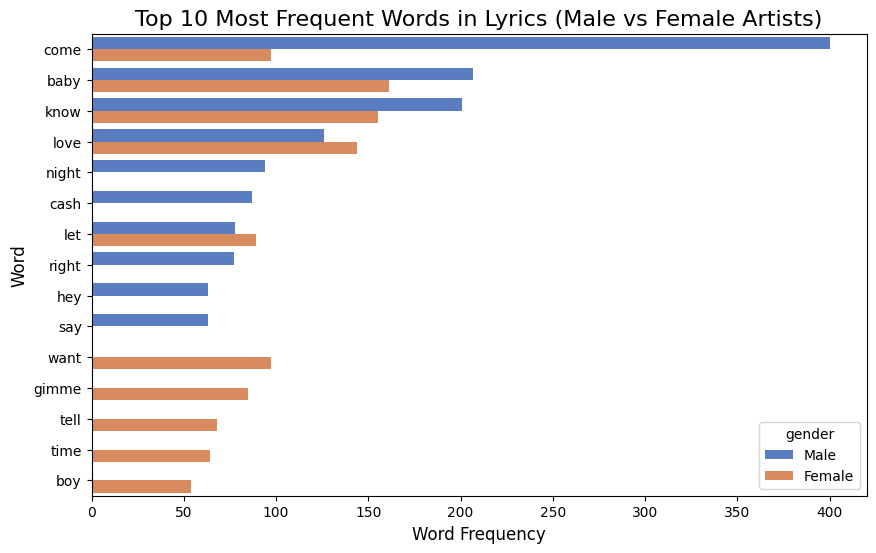

In [30]:
# Call the function with the top frequent words for male and female artists
plot_word_frequencies(male_word_freq, female_word_freq, top_n=10)

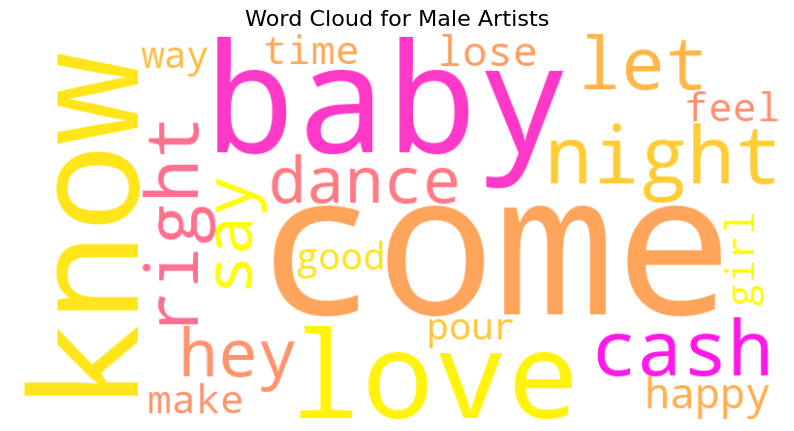

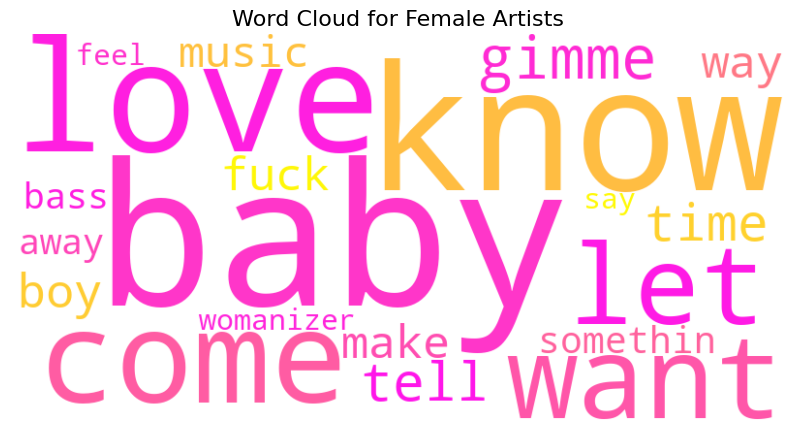

In [31]:
# Plot the word cloud for male and female artists
plot_word_cloud(male_word_freq, title="Word Cloud for Male Artists", save_path="../images/male_wordcloud1.png")
plot_word_cloud(female_word_freq, title="Word Cloud for Female Artists", save_path="../images/female_wordcloud1.png")

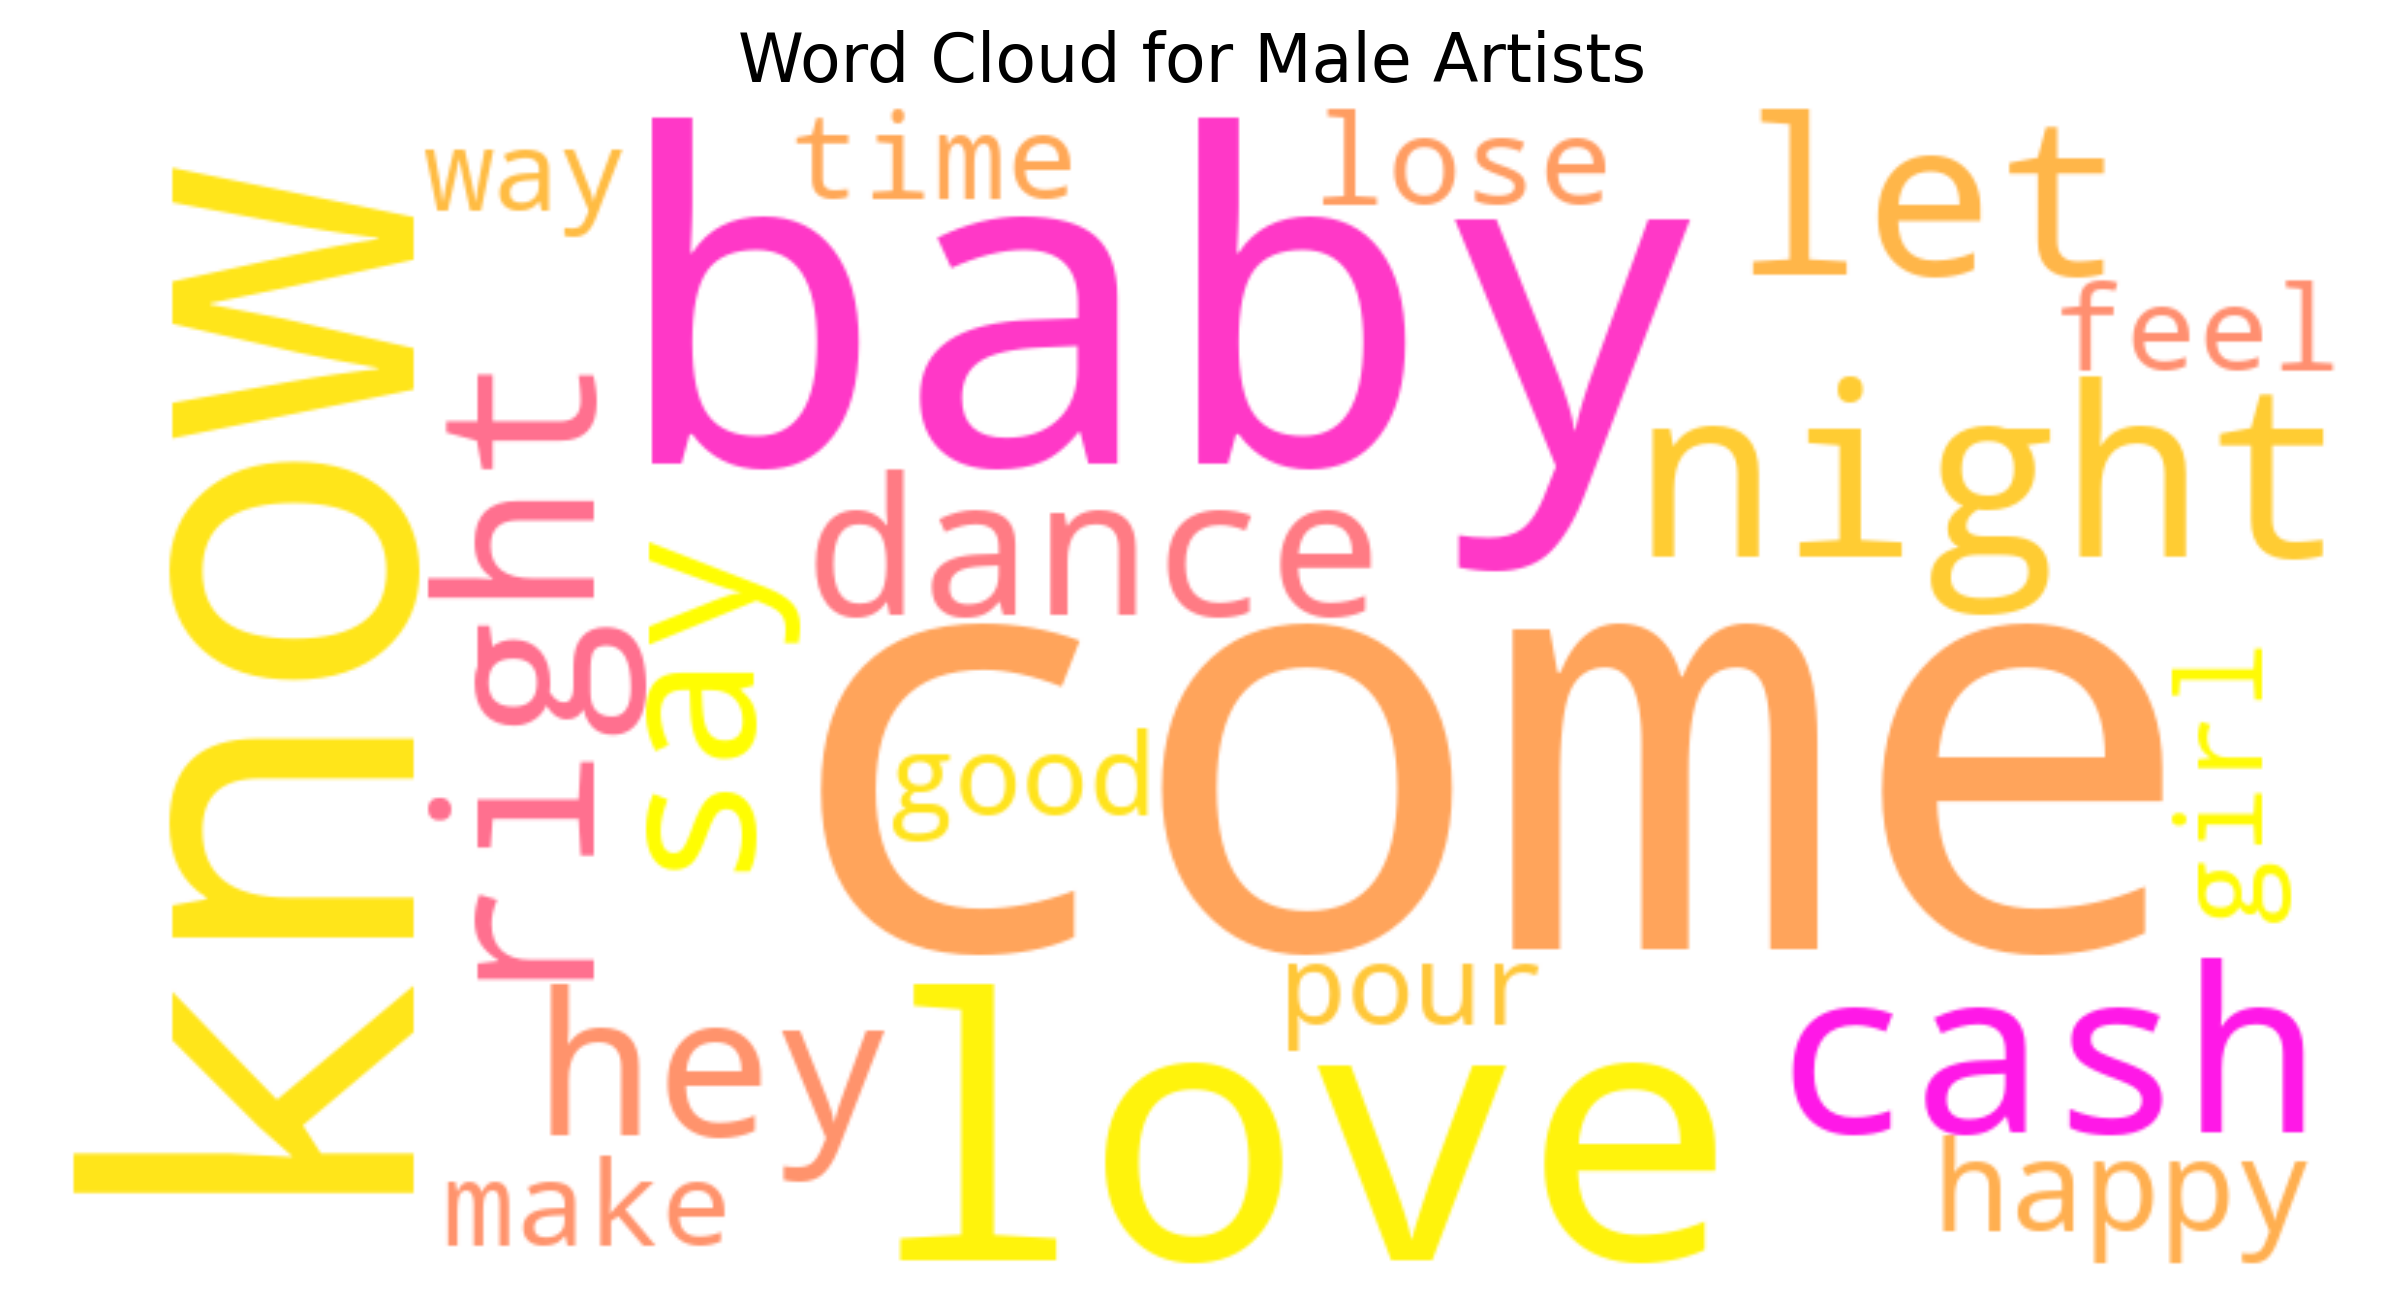

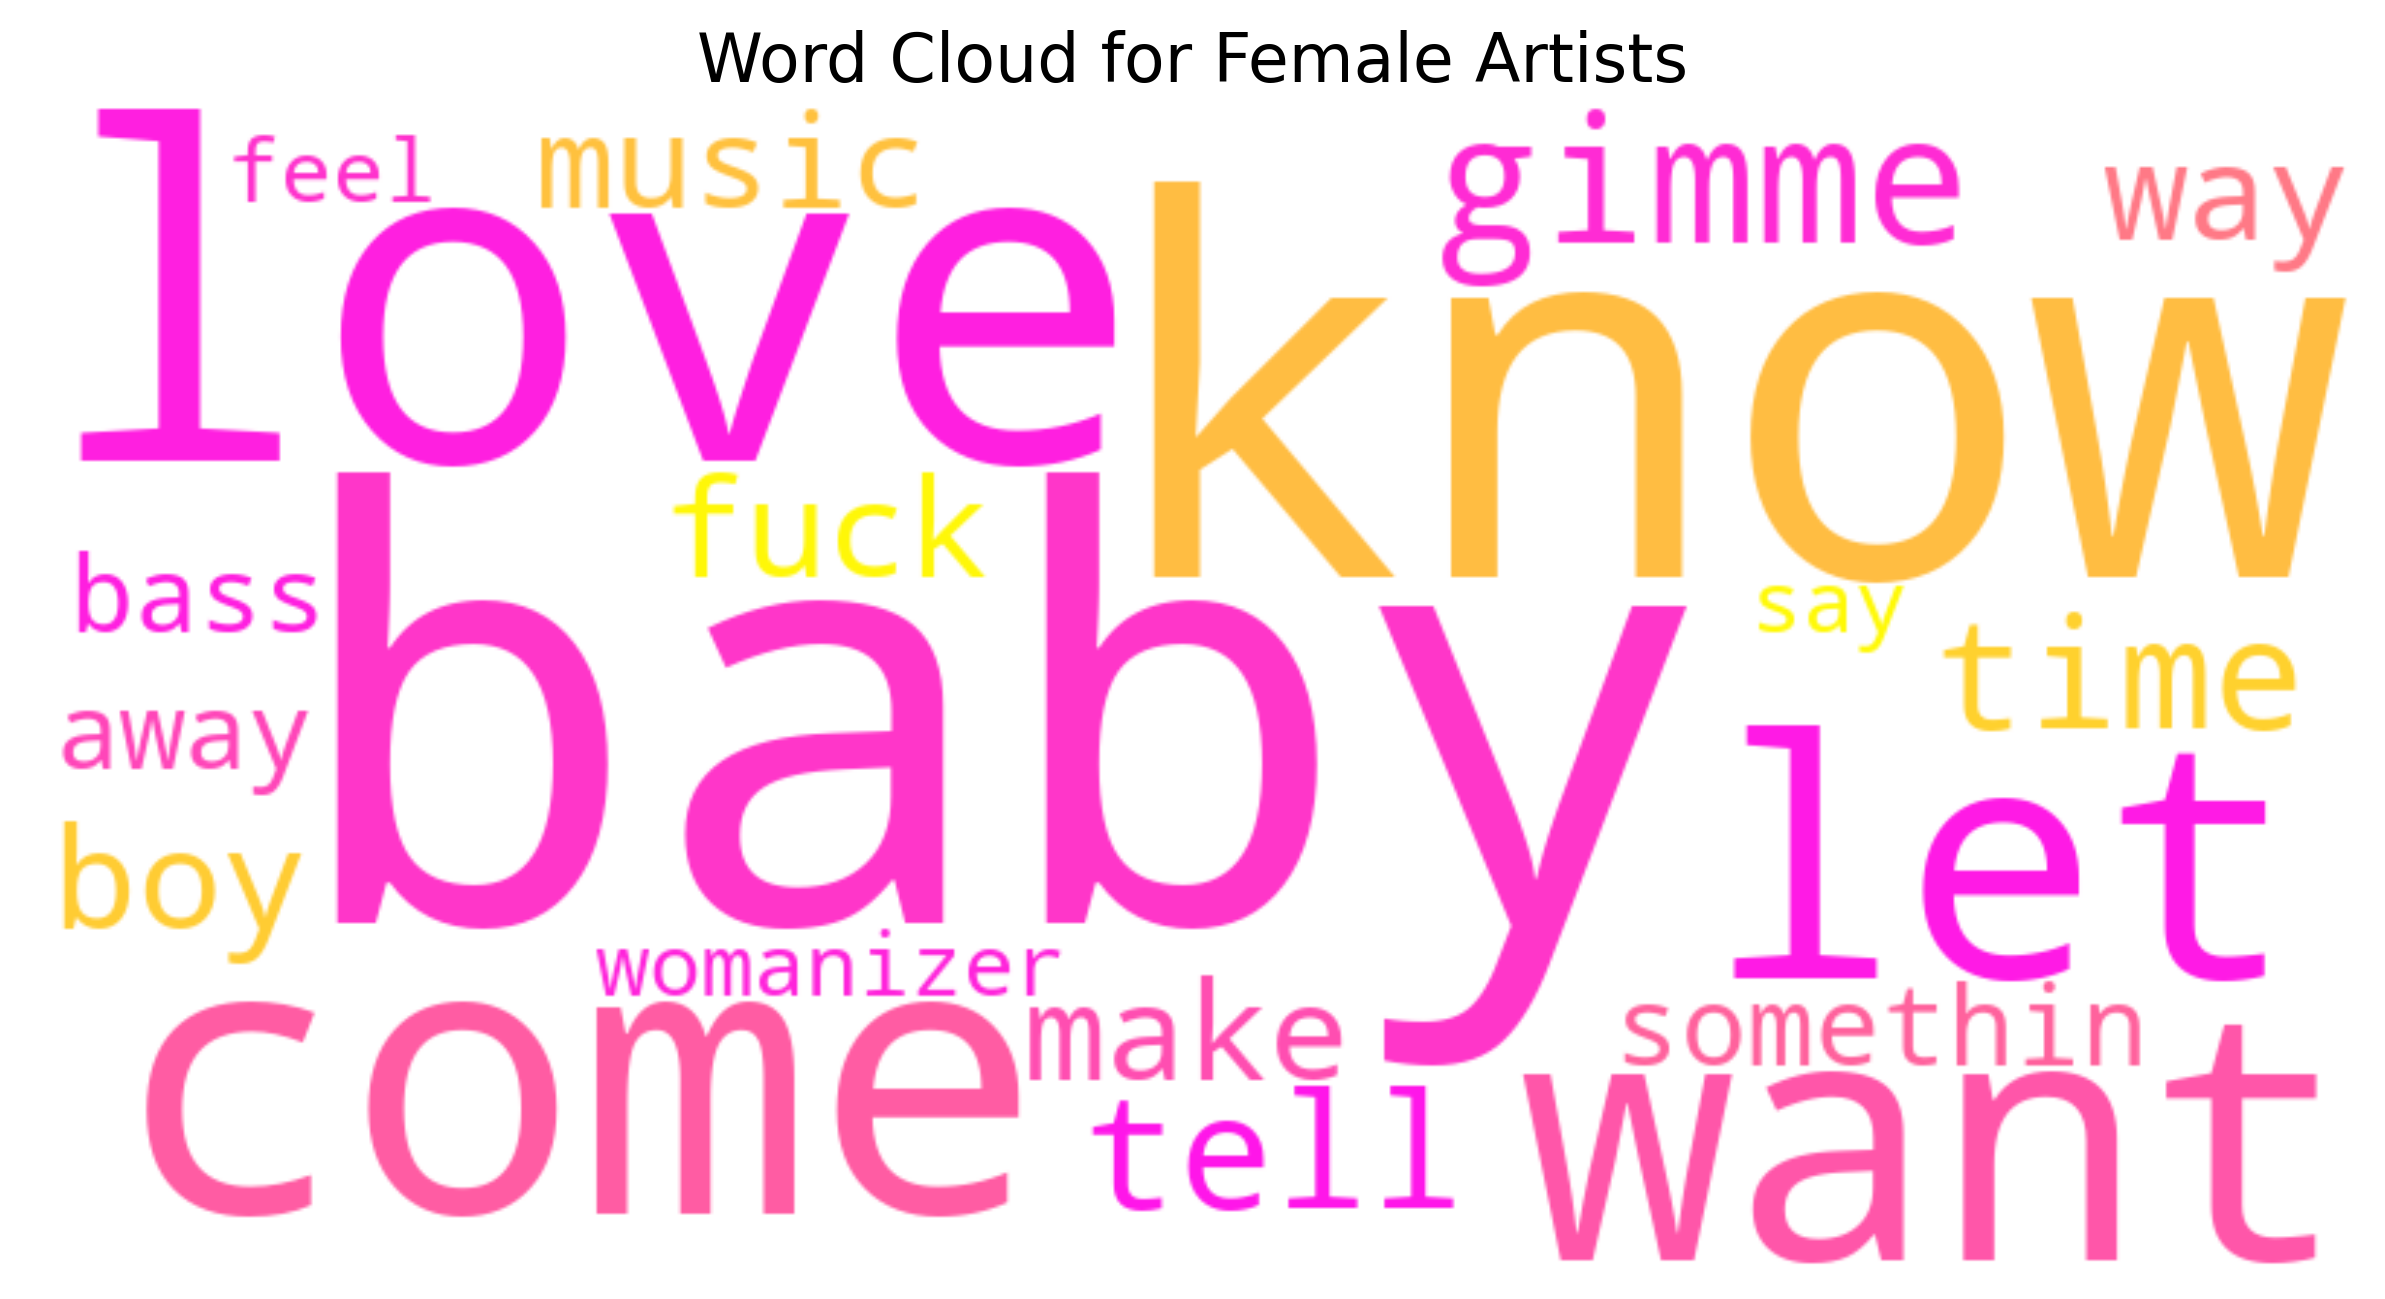

In [32]:
# Path to the PNG image
image_path = "../images/male_wordcloud1.png"

# Display the image
display(Image(filename=image_path))

image_path2 = "../images/female_wordcloud1.png"

display(Image(filename=image_path2))

In [33]:
db_path = '../data/spotify_data.db'
conn = sqlite3.connect(db_path)

# Query the database to retrieve lyrics and gender
query = "SELECT lyrics, gender FROM top_tracks WHERE lyrics IS NOT NULL"
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

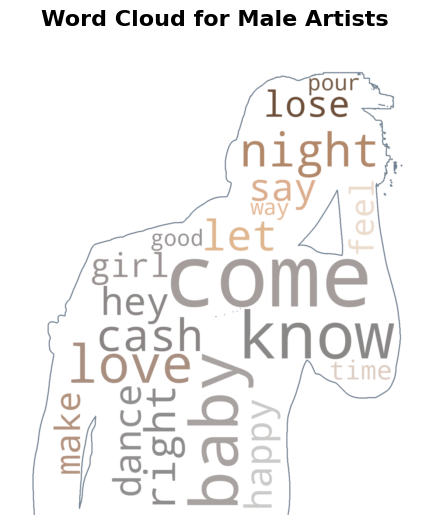

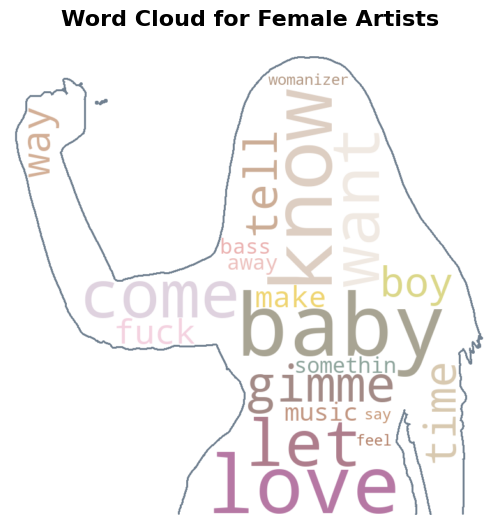

In [34]:
# Example Usage
male_mask_path = "../images/justin_3.png"  # Replace with your mask file path
female_mask_path = "../images/nicki.png"  # Replace with your mask file path

# Increase max_words to get more frequent words in the word cloud
plot_shaped_word_cloud(male_word_freq, mask_path=male_mask_path, title="Word Cloud for Male Artists", max_words=500)
plot_shaped_word_cloud(female_word_freq, mask_path=female_mask_path, title="Word Cloud for Female Artists", max_words=500)


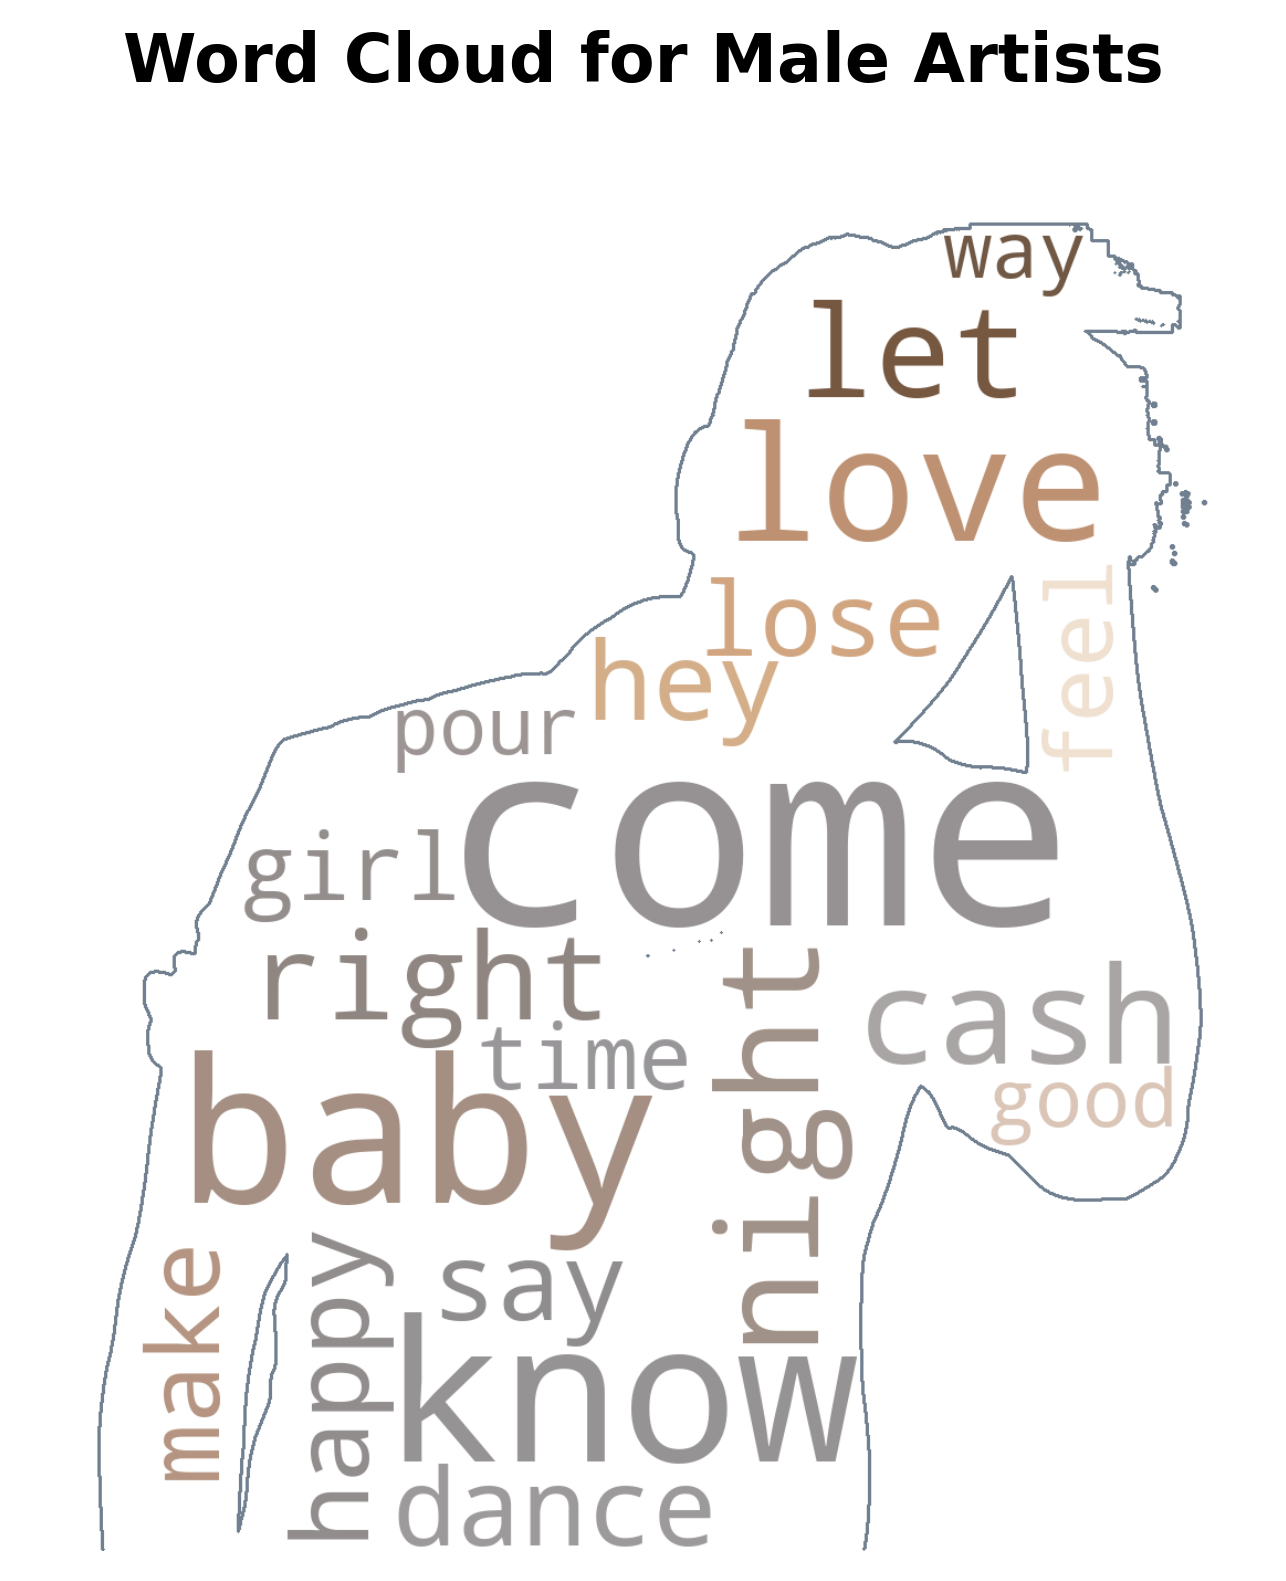

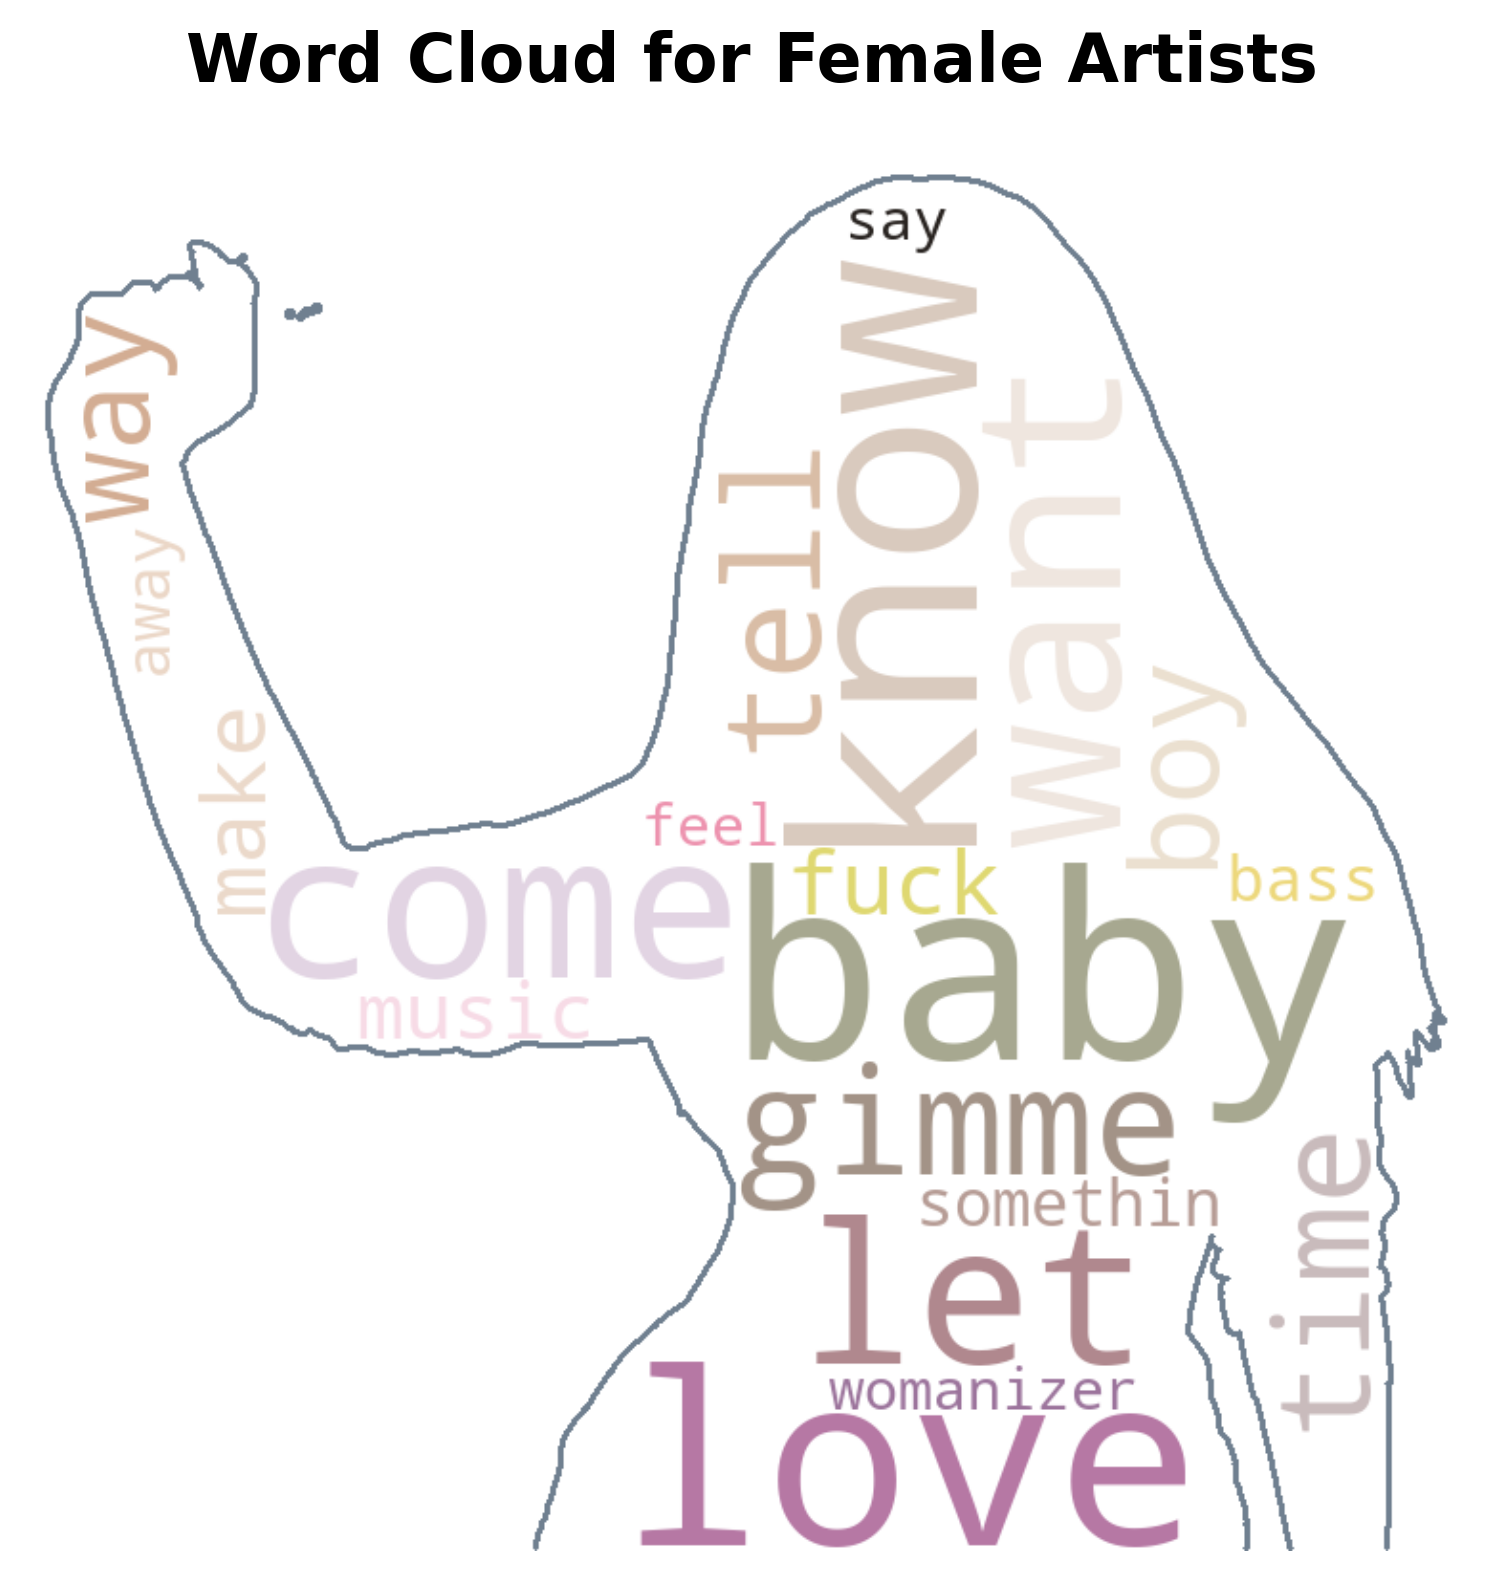

In [36]:
male_wordcloud_path = "../images/male_wordcloud.png"
female_wordcloud_path = "../images/female_wordcloud.png"

display(Image(filename=male_wordcloud_path))
display(Image(filename=female_wordcloud_path))